# Traffic Prediction - DCRNN model

## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic 
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [4]:
!nvidia-smi

Tue Mar 28 22:20:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA P106-100     Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   30C    P5     5W / 120W |    202MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
metr_la_pred = np.load('../demo/dcrnn_predictions_shan.npz')

In [3]:
truth = metr_la_pred['truth']

In [4]:
pred = metr_la_pred['prediction']

In [5]:
pred.shape

(12, 6912, 207)

In [6]:
truth.shape

(12, 6912, 207)

In [17]:
truth[:,0,1]

array([60.375   , 58.25    , 63.77778 , 56.75    , 59.375   , 61.222225,
       56.375   , 58.5     , 53.88889 , 54.625   , 65.44444 , 57.      ],
      dtype=float32)

In [2]:
sensorid = 100
time_window_min = 15

def plot_prediction(sensorid, time_window_min, start_t, end_t):
    idx = time_window_min % 5 
    plt.figure(figsize=(20,5))
    sns.lineplot(data=pred[idx,start_t:end_t,sensorid], label="pred")
    ax = sns.lineplot(data=truth[idx,start_t:end_t,sensorid], label="true")
    ax.set(title=f"sensor id = {sensorid} / predict future {time_window_min} min", xlabel='mile/h', ylabel='time') 

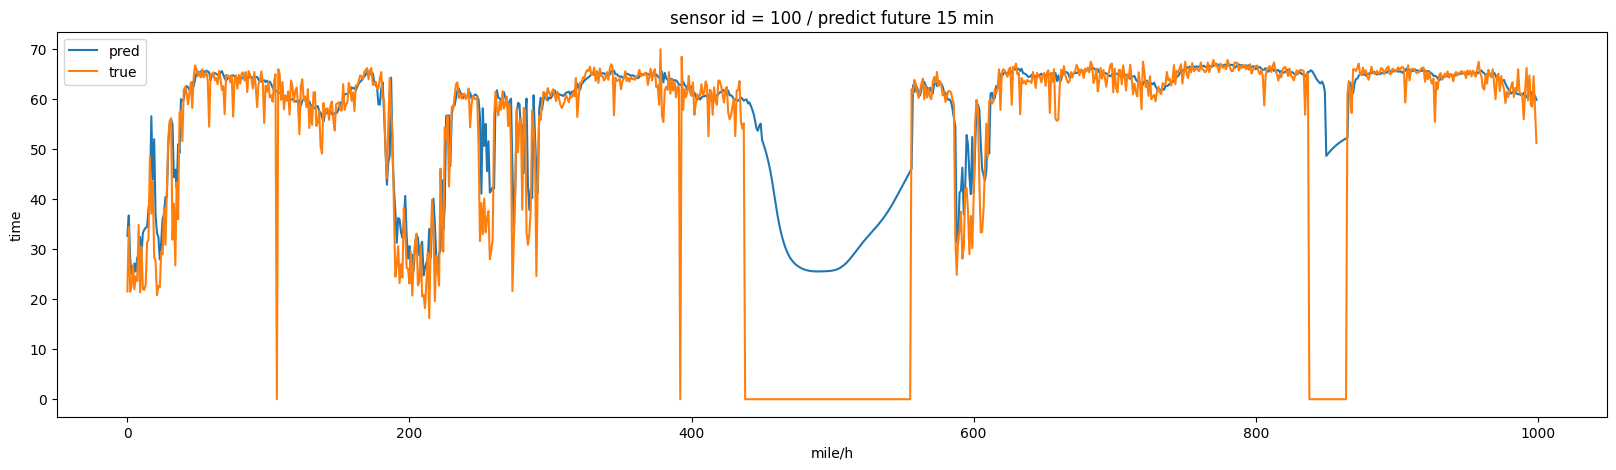

In [41]:
plot_prediction(100, 15, 1000, 2000)

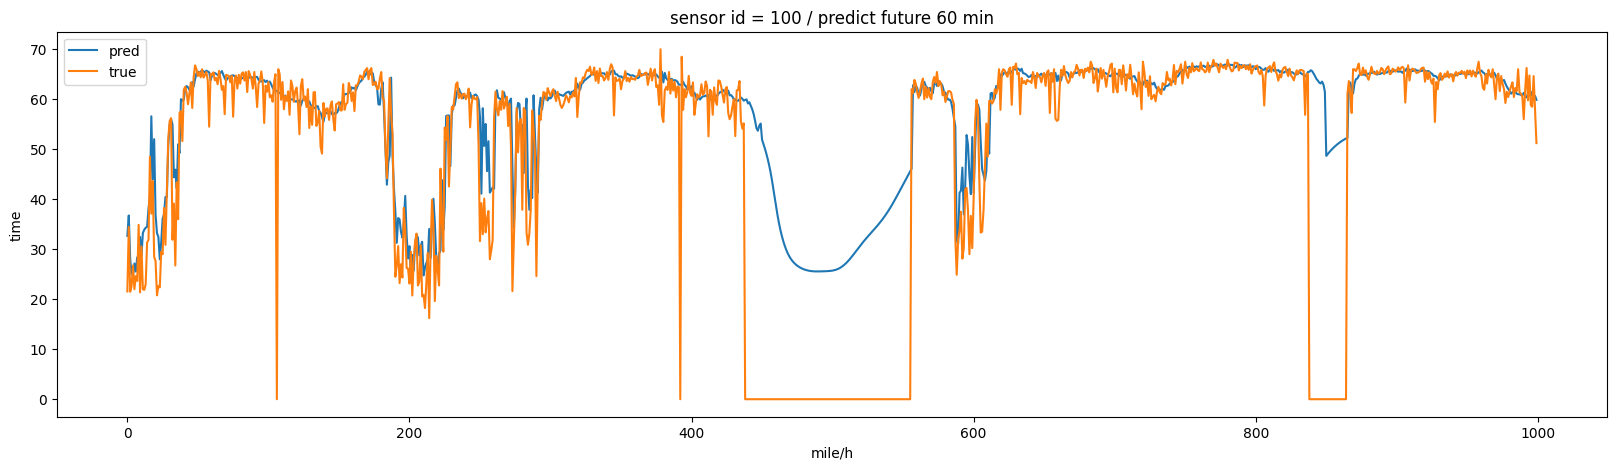

In [42]:
plot_prediction(100, 60, 1000, 2000)

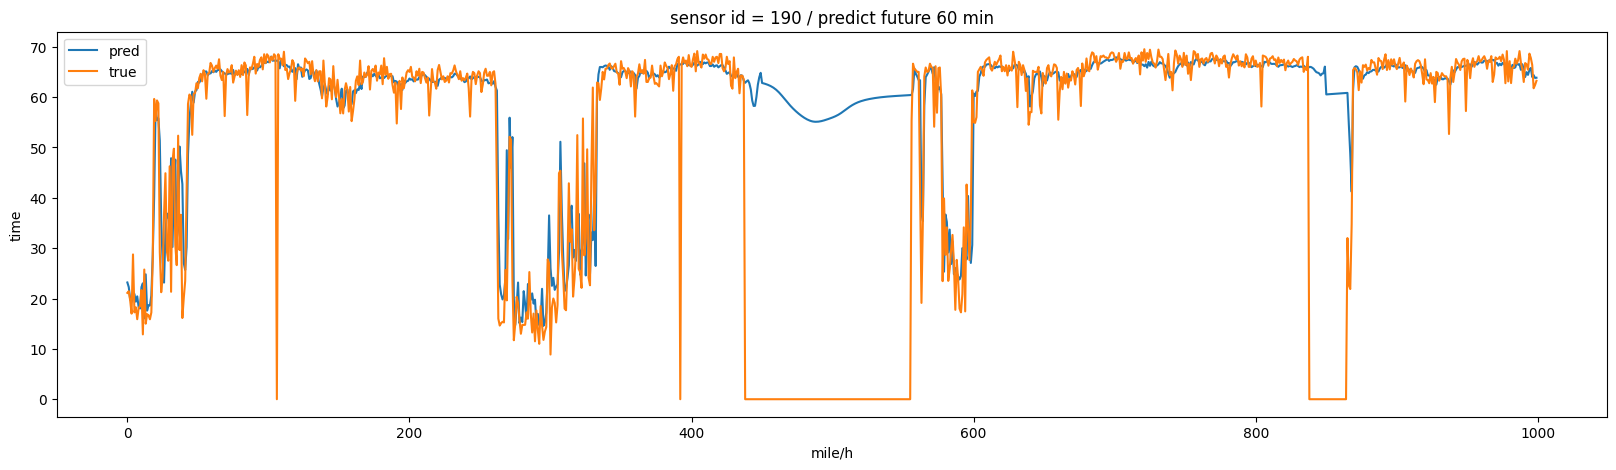

In [45]:
plot_prediction(190, 60, 1000, 2000)

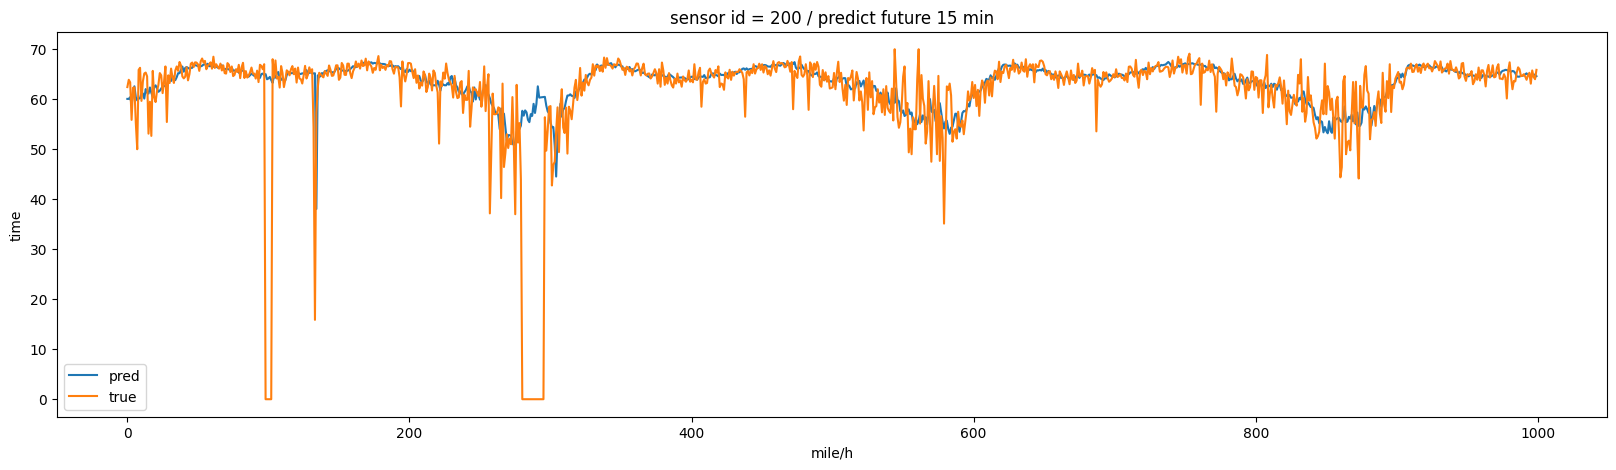

In [48]:
plot_prediction(200, 15, 2000, 3000)

In [3]:
metr_la_pred = np.load('../data/dcrnn_predictions_pytorch.npz')

In [4]:
truth = metr_la_pred['truth']
pred = metr_la_pred['prediction']

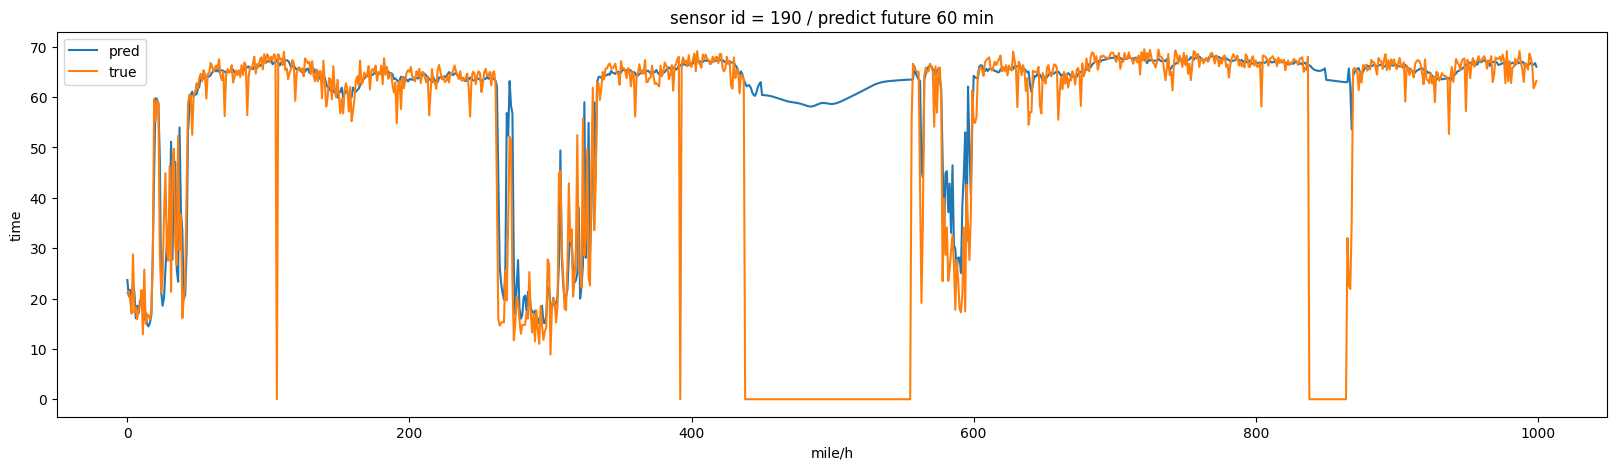

In [6]:
plot_prediction(190, 60, 1000, 2000)

# Traffic forecasting with A3TGCN 

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15135991207477343191
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5633671168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17126973154100005163
physical_device_desc: "device: 0, name: NVIDIA P106-100, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-03-28 22:20:21.204456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 22:20:21.524057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 22:20:21.524669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 22:20:23.964355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 22:20:23.964879: I tensorflow/compiler/xla/stream_executo

In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

1.13.1+cu116


This took some time for me, so be patient :)

In [5]:
!python --version

Python 3.8.10


In [6]:
#!conda install pyg -c pyg

In [7]:
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
#!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
#!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
#!pip install torch-geometric
#!pip install torch-geometric-temporal
#clear_output()

In [8]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(dataset.features))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f6f61506af0>
Number of samples / sequences:  34249


In [10]:
dataset.edge_index.shape

(2, 1722)

#### Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

In [11]:
dataset.edge_index.size

3444

In [12]:
len(dataset.features)

34249

In [13]:
# Show first sample
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [14]:
# Important: It is not always like that!
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
d = ChickenpoxDatasetLoader().get_dataset(lags=4)
next(iter(d))

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

You can always have a look at the source-code to see how a dataset is constructed. Chickenpox would be a classical "predict-next-timestep" dataset (the label is one step later than the features).  
METR-LA would be a sequence-to-sequence prediction dataset that predicts further into the future than just the next timestep. You can also see, that the features are used as label as well.



```
# >>> From the ChickenpoxDatasetLoader <<<
self.features = [
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
self.targets = [
            stacked_target[i + self.lags, :].T  
            for i in range(stacked_target.shape[0] - self.lags)
        ]

# >>> From METRLADatasetLoader <<<
indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]
for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())
```



<AxesSubplot: >

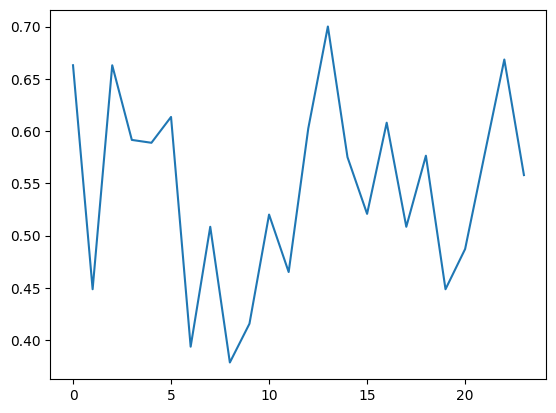

In [15]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

#### Test Train Split

In [16]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [17]:
print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))

Number of train buckets:  27399
Number of test buckets:  6850


## Model

Which model to choose depends on which time-series task you work on. 

- A3TGCN is an extension of TGCN that uses attention 
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
#from torch_geometric_temporal.nn.recurrent import DCRNN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

## Training

- Training on GPU didn't bring much speed-up
- I ran into RAM issues, why I only train on a smaller subset of the data

In [19]:
# GPU support
device = torch.device('cuda') #cpu') # ('cpu')  ('cuda')

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

```python
# original code
print("Running training...")
for epoch in range(epoch): 
    loss = 0
    step = 0
    for snapshot in train_dataset[1000:]:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))
```

In [20]:
!pwd

/home/shan/Spaces/Personal/graph-ml


In [19]:
checkpoint = torch.load('./A3TGCN_gitlab_subset_1000_epoch_10_resumable')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [20]:
subset = 1000
max_epoch = 20

log = []

def train_minibatch(offset, dataset):
    print(f"{offset} Running training...")
    for epoch in range(max_epoch): 
        loss = 0
        step = 0
        #offset = 0
        for snapshot in dataset: #[int(subset*offset):int(subset*(offset+1))]:
            snapshot = snapshot.to(device)
            # Get model predictions
            y_hat = model(snapshot.x, snapshot.edge_index)
            # Mean squared error
            loss = loss + torch.mean((y_hat-snapshot.y)**2) 
            step += 1

        loss = loss / (step + 1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        log.append("{} - Epoch {} train MSE: {:.4f}".format(offset, epoch, loss.item()))

In [21]:
#for offset in range(int(len(train_dataset.features) / subset) + 1):
for offset in range(5):
    #print ( offset )
    minibatch_dataset = train_dataset[int(subset*offset):int(subset*(offset+1))]
    #print(minibatch_dataset)
    torch.cuda.empty_cache()
    train_minibatch(offset, minibatch_dataset)
    print(log[-1])
    

0 Running training...
0 - Epoch 19 train MSE: 0.3555
1 Running training...
1 - Epoch 19 train MSE: 0.6082
2 Running training...
2 - Epoch 19 train MSE: 0.6067
3 Running training...
3 - Epoch 19 train MSE: 0.4303
4 Running training...
4 - Epoch 19 train MSE: 0.3362


In [22]:
torch.save(model, './A3TGCN_gitlab_subset_1000_epoch_20_mb_5_v2')

In [23]:
torch.save({
            'epoch': 20,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, './A3TGCN_gitlab_subset_1000_epoch_20_v2_mb_5_resumable')

In [29]:
54.798 * subset

27399.0

In [ ]:
log

In [ ]:
for i in range(0

## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [24]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6251


### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

Data points:, (289,)


<Axes: >

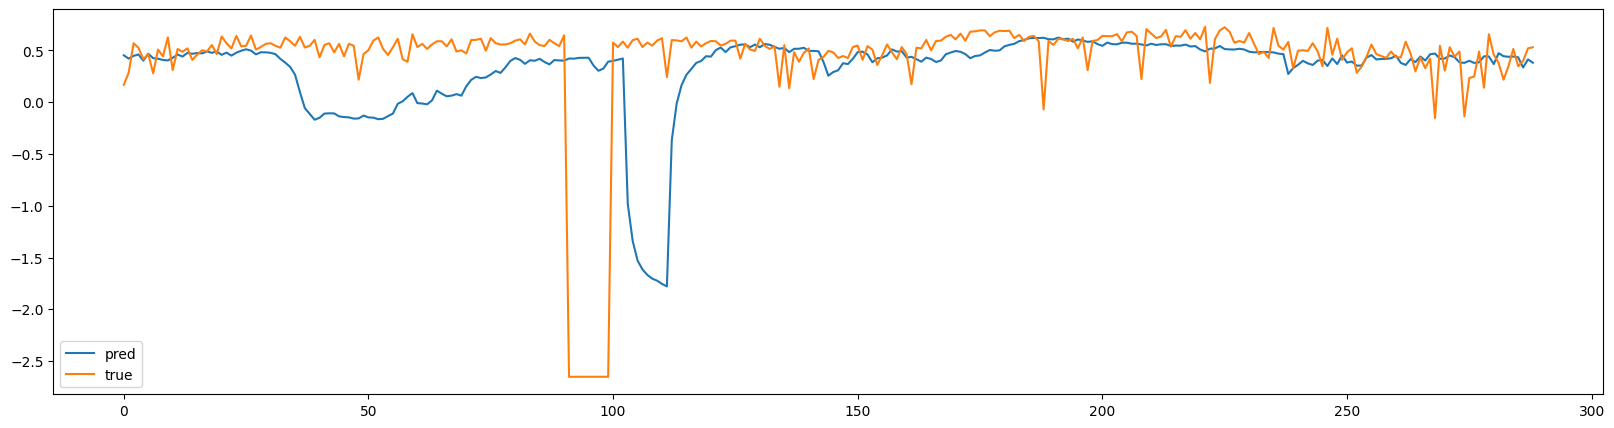

In [25]:
import numpy as np

sensor = 1
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

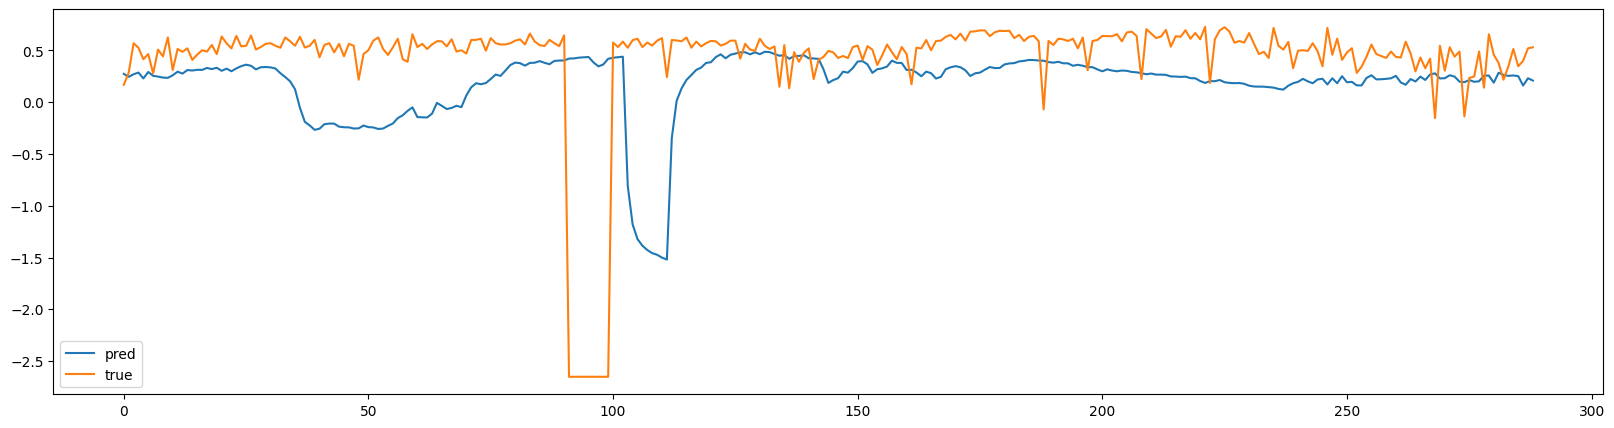

In [24]:
import numpy as np

sensor = 1
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

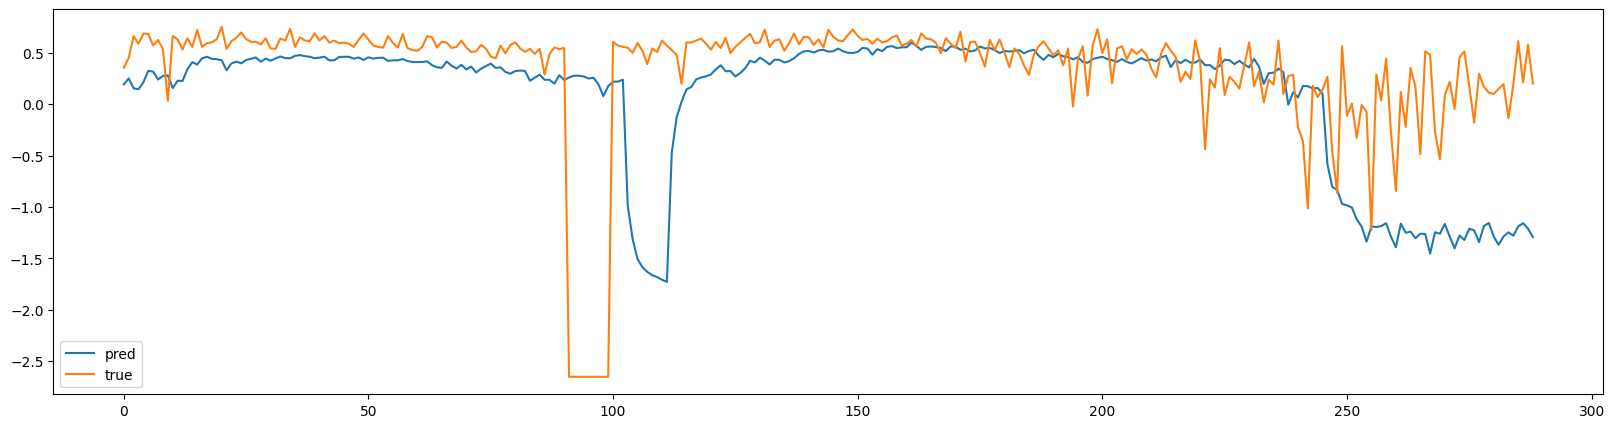

In [26]:
import numpy as np

sensor = 200
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

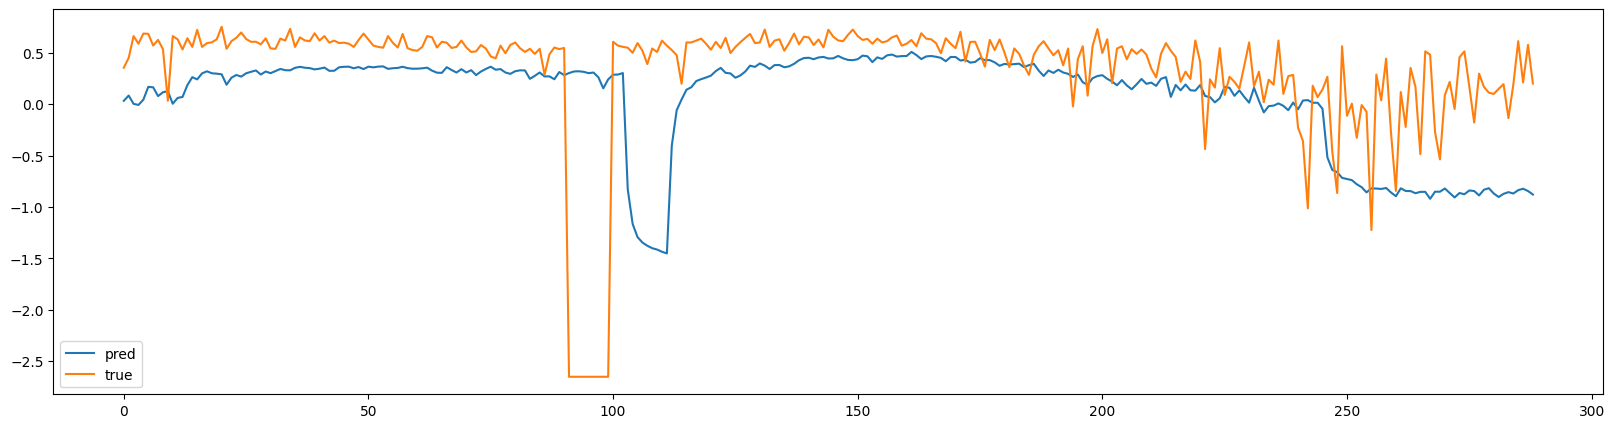

In [25]:
import numpy as np

sensor = 200
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

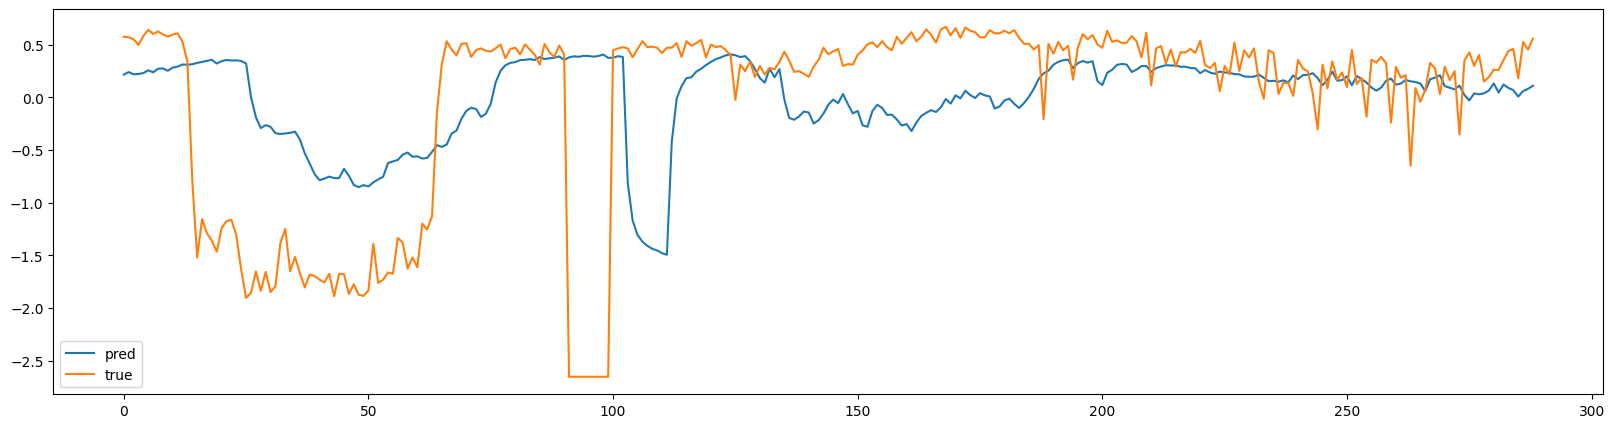

In [26]:
import numpy as np

sensor = 100
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

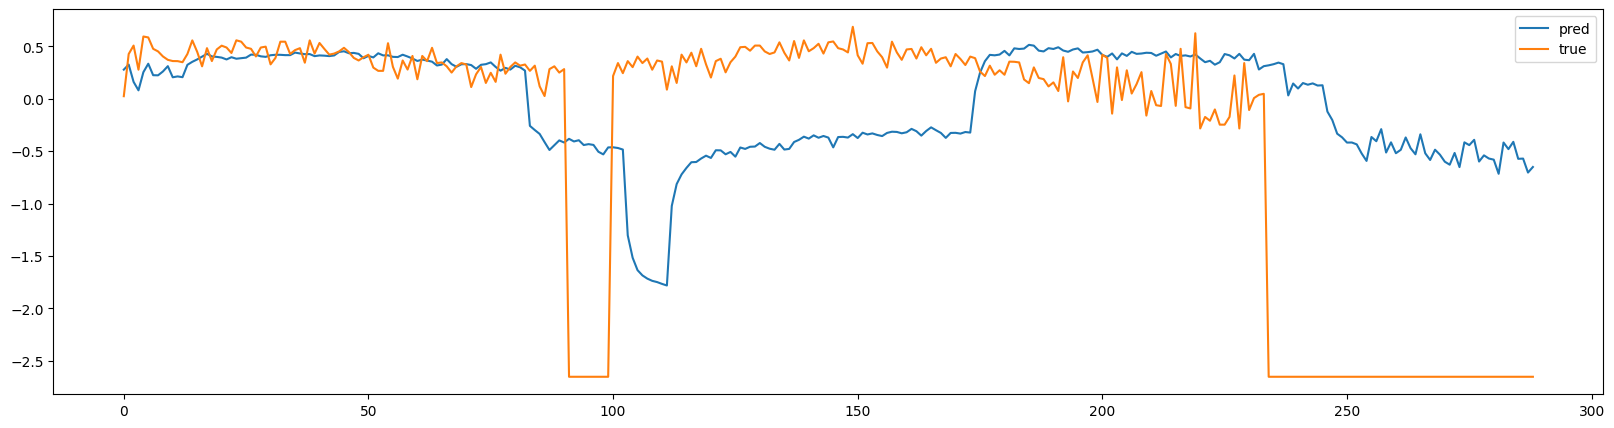

In [30]:
import numpy as np

sensor = 50
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

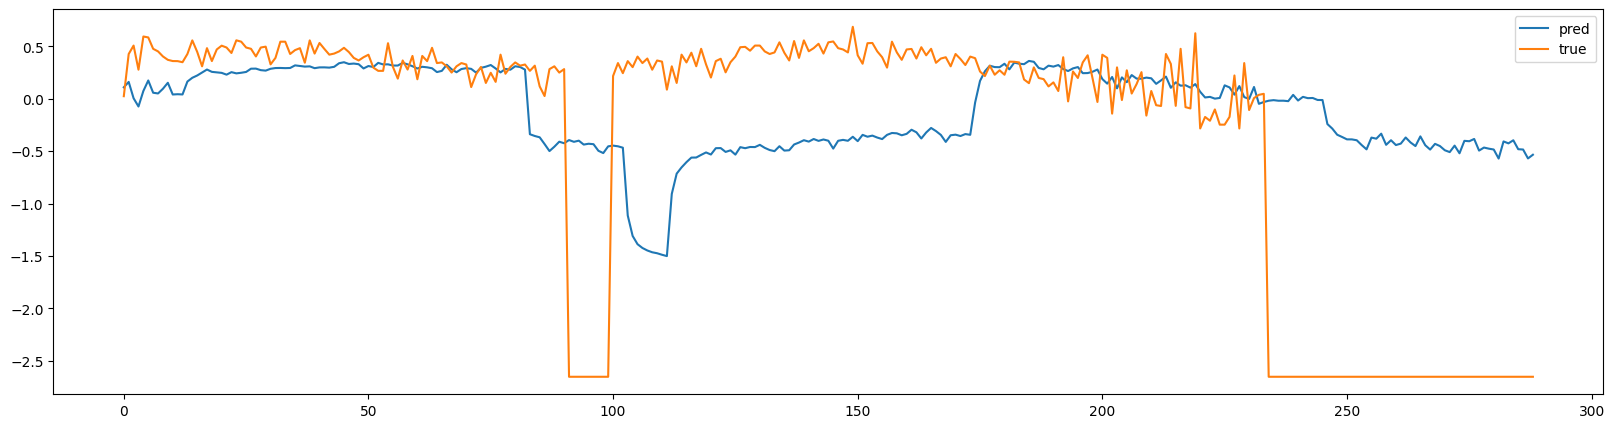

In [28]:
import numpy as np

sensor = 50
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

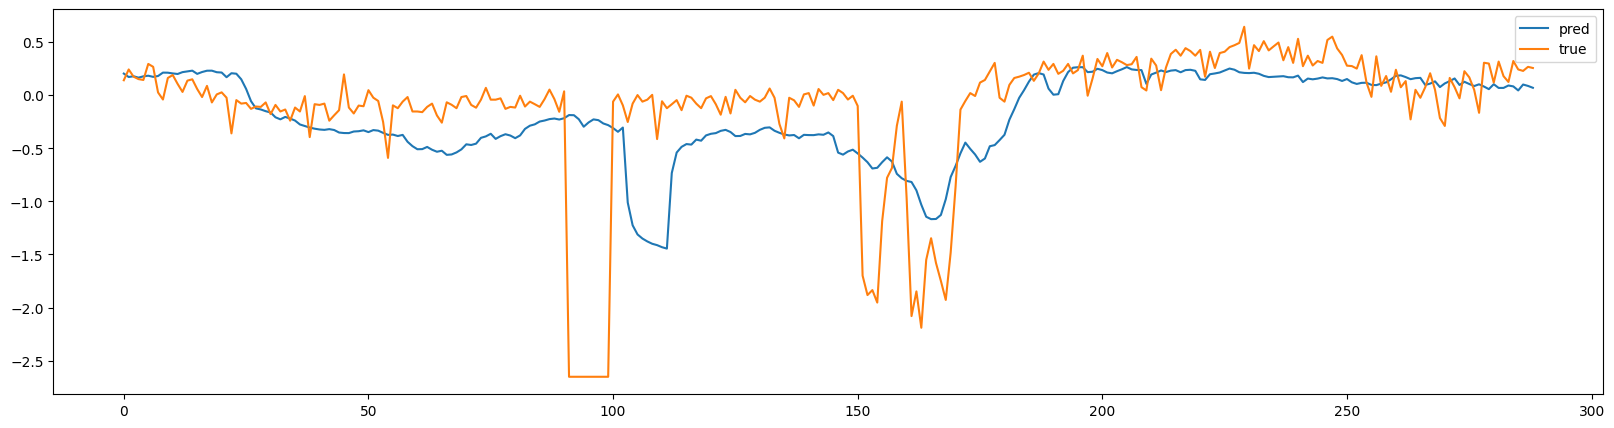

In [29]:
import numpy as np

sensor = 3
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

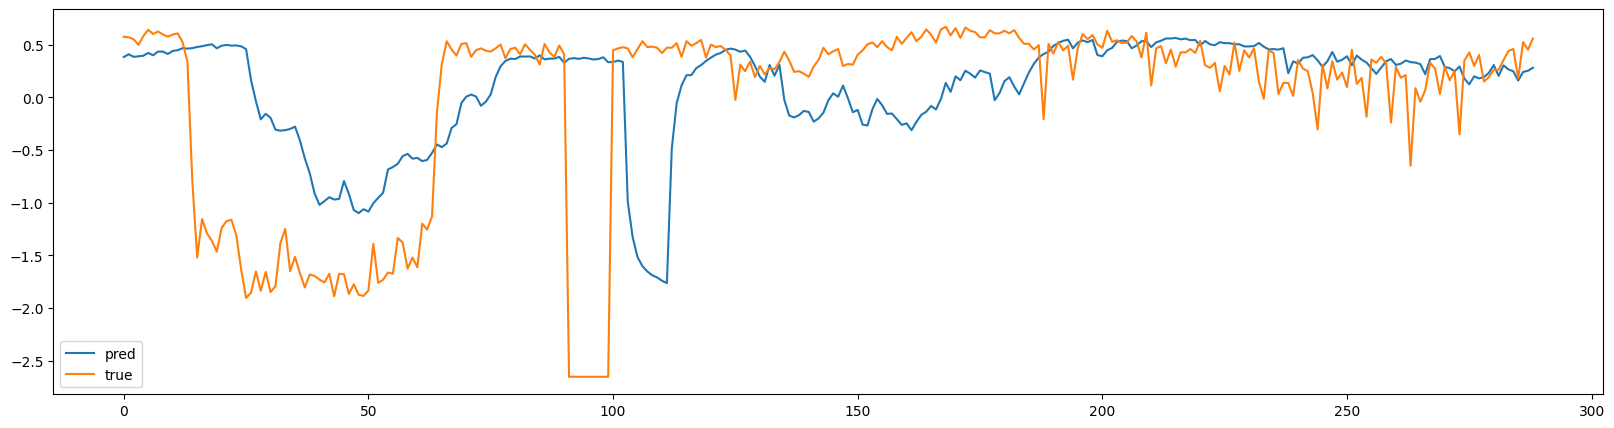

In [29]:
import numpy as np

sensor = 100
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

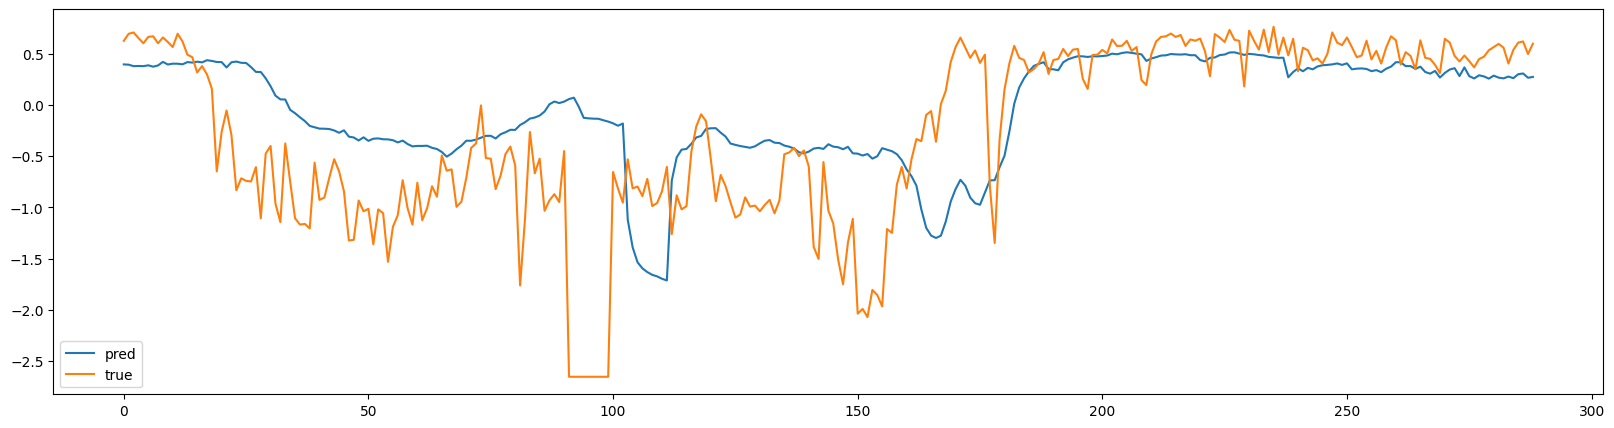

In [27]:
import numpy as np

sensor = 4
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Data points:, (289,)


<Axes: >

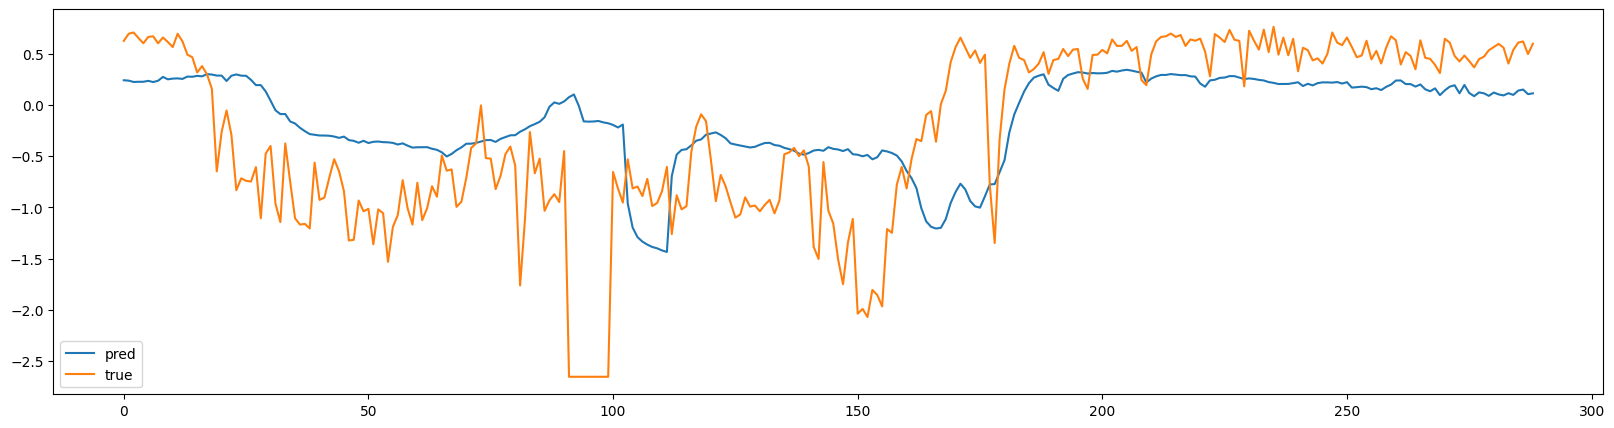

In [38]:
import numpy as np

sensor = 4
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

In [27]:
import gc
torch.cuda.empty_cache()
gc.collect()

981

In [29]:
for snapshot in train_dataset[:1] :
    print(snapshot)

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


In [37]:
subset = 600

print("Running training...")
for epoch in range(10): 
    loss = 0
    step = 0
    offset = 0
    for snapshot in train_dataset[int(subset*offset):]:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
            torch.cuda.empty_cache()
            offset +=1
            

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 5.93 GiB total capacity; 5.32 GiB already allocated; 2.69 MiB free; 5.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [34]:
len(train_dataset.features)

27399

In [35]:
27399/1000

27.399

### Save the entire model

In [34]:
torch.save(model, 'A3TGCN_gitlab_subset_1000_epoch_10')

### Save checkpoint for resuming training

In [35]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'A3TGCN_gitlab_subset_1000_epoch_10_resumable')

In [36]:
model = torch.load('A3TGCN_gitlab_subset_1000_epoch_10')
model.eval()

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [2]:
for i in range(3,10):
    print(i)

3
4
5
6
7
8
9
